In [1]:
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy import stats
from truesight.preprocessing import Preprocessor
from truesight.core import TrueSight
from truesight.metrics import Evaluator, smape, mape, mse, rmse, mae
from sklearn.metrics import r2_score
from truesight.utils import generate_syntetic_data

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
num_time_steps = 60
season_length = 12
forecast_horizon = 12
df = generate_syntetic_data(num_time_steps, season_length, 500)

In [3]:
from statsforecast.models import SeasonalNaive, AutoETS, AutoARIMA
from sklearn.linear_model import LinearRegression
from truesight.utils import ModelWrapper

models = [
    ModelWrapper(LinearRegression, horizon=forecast_horizon, season_length=season_length, alias="LinearRegression"),
    ModelWrapper(AutoETS, horizon=forecast_horizon, season_length=season_length),
    ModelWrapper(AutoARIMA, horizon=forecast_horizon, season_length=season_length),
]

preprocessor = Preprocessor(df)
X_train, Y_train, ids_train, X_val, Y_val, ids_val, models = preprocessor.make_dataset(
    forecast_horizon = forecast_horizon, 
    season_length = season_length,
    date_freq = "MS", 
    models = models, 
    fallback_model = ModelWrapper(SeasonalNaive, horizon=forecast_horizon, season_length=season_length),
    verbose = True
    )

100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


In [4]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 20, restore_best_weights = True, monitor = "val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 10, verbose = False),
]

Epoch 1/1000
13/13 [==============================] - 9s 324ms/step - loss: 47282.5039 - val_loss: 47862.5156 - lr: 1.0000e-04
Epoch 2/1000
13/13 [==============================] - 4s 285ms/step - loss: 39450.4180 - val_loss: 35741.3750 - lr: 1.0000e-04
Epoch 3/1000
13/13 [==============================] - 4s 284ms/step - loss: 25660.7520 - val_loss: 23454.0078 - lr: 1.0000e-04
Epoch 4/1000
13/13 [==============================] - 4s 284ms/step - loss: 15909.8691 - val_loss: 15364.7363 - lr: 1.0000e-04
Epoch 5/1000
13/13 [==============================] - 4s 286ms/step - loss: 10861.8721 - val_loss: 9289.7090 - lr: 1.0000e-04
Epoch 6/1000
13/13 [==============================] - 4s 283ms/step - loss: 6253.9058 - val_loss: 5311.5737 - lr: 1.0000e-04
Epoch 7/1000
13/13 [==============================] - 4s 284ms/step - loss: 3921.3826 - val_loss: 3297.3752 - lr: 1.0000e-04
Epoch 8/1000
13/13 [==============================] - 4s 288ms/step - loss: 2853.8730 - val_loss: 3089.7290 - lr: 1.

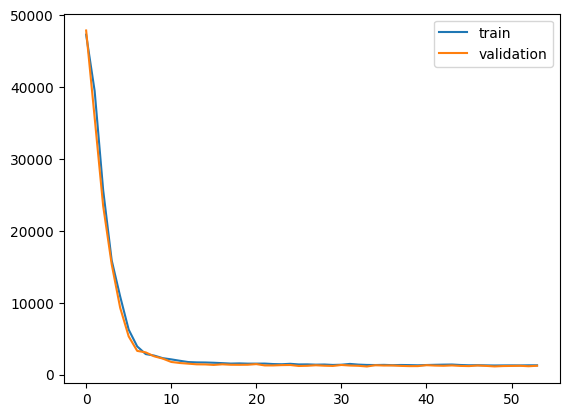

In [5]:
models_nocov = models[-1:]
X_train_nocov = X_train[-1:]
X_val_nocov = X_val[-1:]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
ts_nocov = TrueSight(models_nocov, forecast_horizon, filter_size = 64, context_size = 256, hidden_size = 1024, dropout_rate = 0.1)
ts_nocov.compile(optimizer=optimizer, loss='mse')

ts_nocov.fit(
    x = X_train_nocov, y = Y_train,
    validation_data = [X_val_nocov, Y_val],
    batch_size = 32,
    epochs = 1000,
    verbose = True,
    callbacks = callbacks,
)
ts_nocov.plot_training_history()
ts_nocov.save_weights('nocov.h5')

Epoch 1/1000
13/13 [==============================] - 8s 308ms/step - loss: 47434.8008 - val_loss: 48397.4609 - lr: 1.0000e-04
Epoch 2/1000
13/13 [==============================] - 4s 271ms/step - loss: 40240.0195 - val_loss: 36761.2109 - lr: 1.0000e-04
Epoch 3/1000
13/13 [==============================] - 3s 272ms/step - loss: 27202.1445 - val_loss: 26147.4121 - lr: 1.0000e-04
Epoch 4/1000
13/13 [==============================] - 3s 270ms/step - loss: 19649.6113 - val_loss: 19474.2305 - lr: 1.0000e-04
Epoch 5/1000
13/13 [==============================] - 4s 273ms/step - loss: 16207.9238 - val_loss: 16033.3672 - lr: 1.0000e-04
Epoch 6/1000
13/13 [==============================] - 4s 276ms/step - loss: 11867.8311 - val_loss: 8624.4170 - lr: 1.0000e-04
Epoch 7/1000
13/13 [==============================] - 4s 282ms/step - loss: 5911.8579 - val_loss: 4308.9546 - lr: 1.0000e-04
Epoch 8/1000
13/13 [==============================] - 4s 279ms/step - loss: 3401.2324 - val_loss: 2935.0166 - lr: 

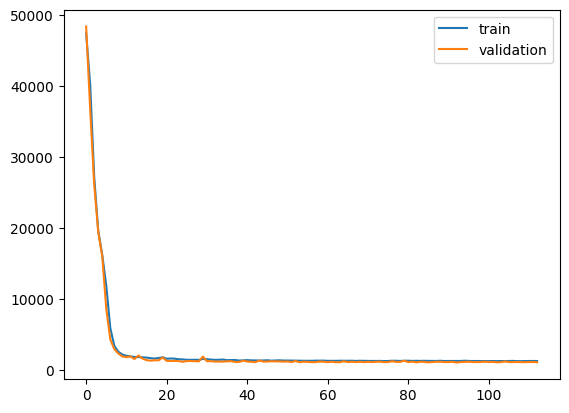

In [6]:
models_wcov = models.copy()
X_train_wcov = X_train.copy()
X_val_wcov = X_val.copy()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
ts_wcov= TrueSight(models_wcov, forecast_horizon, filter_size = 64, context_size = 256, hidden_size = 1024, dropout_rate = 0.1)
ts_wcov.compile(optimizer=optimizer, loss='mse')

ts_wcov.fit(
    x = X_train_wcov, y = Y_train,
    validation_data = [X_val_wcov, Y_val],
    batch_size = 32,
    epochs = 1000,
    verbose = True,
    callbacks = callbacks,
)
ts_wcov.plot_training_history()
ts_wcov.save_weights('ts_wcov.h5')

In [7]:
yhat_nocov = ts_nocov.predict(X_val_nocov, n_repeats = 100, n_quantiles = 15, verbose = False)
yhat_wcov = ts_wcov.predict(X_val_wcov, n_repeats = 100, n_quantiles = 15, verbose = False)

In [8]:
evaluator_wcov = Evaluator(X_val, Y_val, yhat_wcov, ids_val)
evaluator_wcov.evaluate_prediction(evaluators = [smape, mape, mse, rmse, mae], return_mean = True)

smape       0.549451
mape        0.414327
mse      1080.414435
rmse       21.672101
mae        17.436016
dtype: float64

In [9]:
evaluator_nocov = Evaluator(X_val, Y_val, yhat_nocov, ids_val)
evaluator_nocov.evaluate_prediction(evaluators = [smape, mape, mse, rmse, mae], return_mean = True)

smape       0.807919
mape        0.584127
mse      1158.042616
rmse       22.478076
mae        18.436885
dtype: float64

In [10]:
group_a = smape(Y_val, yhat_wcov.mean(axis=0))
group_b = smape(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_rel(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -5.2818451529915516
P-Value: 7.599578958485774e-07


In [11]:
group_a = mape(Y_val, yhat_wcov.mean(axis=0))
group_b = mape(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_rel(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -3.769617097239496
P-Value: 0.000278131361370289


In [12]:
group_a = mse(Y_val, yhat_wcov.mean(axis=0))
group_b = mse(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_rel(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -1.3089329294732113
P-Value: 0.19358726772670296


In [13]:
group_a = rmse(Y_val, yhat_wcov.mean(axis=0))
group_b = rmse(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_rel(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -1.531001334316184
P-Value: 0.12895833328030845


In [14]:
group_a = mae(Y_val, yhat_wcov.mean(axis=0))
group_b = mae(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_rel(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -2.1633841262133267
P-Value: 0.03291834217696799
